In [101]:
import pandas as pd
import numpy as np
from gaia_download import get_masses
import matplotlib.pyplot as plt
from download_isochrone import load_isochrone
from astropy.coordinates import SkyCoord, ICRS, Galactocentric
import astropy.units as u
from simbad_download import resolve_name

In [2]:
CLUSTER_NAME: str = 'NGC 188'
ROOT_PATH: str = f'data/{CLUSTER_NAME}'

# Mass

In [3]:
clustered = pd.read_csv(f'{ROOT_PATH}/{CLUSTER_NAME}_clustered.csv')
isochrone = load_isochrone(f'{ROOT_PATH}/{CLUSTER_NAME}_isochrone.dat')

In [4]:
clustered = pd.merge(clustered, get_masses(clustered.source_id), on='source_id')

In [5]:
clustered_w_mass = clustered.dropna(subset=['mass_flame'])

In [6]:
clustered_w_mass_values = clustered_w_mass[['BP-RP', 'G_abs', 'mass_flame']].values

In [7]:
clustered_w_mass_values[:, :2].shape

(817, 2)

In [8]:
isochrone.shape

(299, 2)

In [36]:
BOUNDS = np.max(isochrone, axis=0)-np.min(isochrone, axis=0)

In [37]:
def find_closest(x):
    return clustered_w_mass_values[np.argmin(np.linalg.norm((x/BOUNDS-clustered_w_mass_values[:, [0, 1]]/BOUNDS), axis=1).flatten())][2]

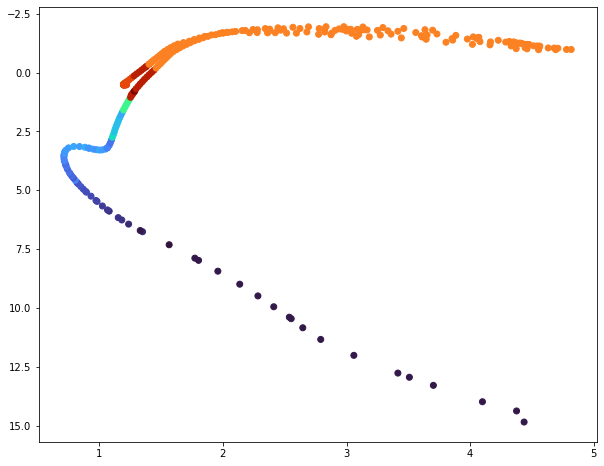

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(isochrone[:, 0], isochrone[:, 1], c=np.apply_along_axis(find_closest, axis=1, arr=isochrone),
            cmap='turbo')
plt.gca().invert_yaxis();

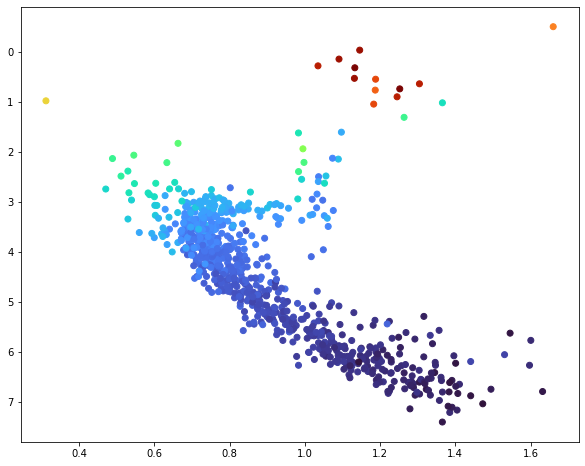

In [40]:
plt.figure(figsize=(10, 8))
plt.scatter(clustered_w_mass['BP-RP'], clustered_w_mass['G_abs'],
            c=clustered_w_mass['mass_flame'], cmap='turbo')
plt.gca().invert_yaxis();

In [41]:
clustered_without_mass = clustered[np.isnan(clustered['mass_flame'])]

In [43]:
clustered_without_mass['mass_flame'] = np.apply_along_axis(find_closest, axis=1, arr=clustered_without_mass[['BP-RP', 'G_abs']])

/tmp/ipykernel_12627/1298936366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_without_mass['mass_flame'] = np.apply_along_axis(find_closest, axis=1, arr=clustered_without_mass[['BP-RP', 'G_abs']])


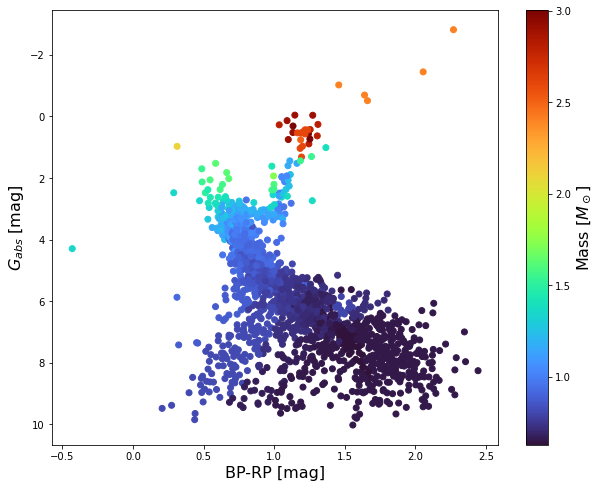

In [174]:
plt.figure(figsize=(10, 8))
plt.scatter(clustered_w_mass['BP-RP'], clustered_w_mass['G_abs'],
            c=clustered_w_mass['mass_flame'], cmap='turbo')
plt.scatter(clustered_without_mass['BP-RP'], clustered_without_mass['G_abs'],
            c=clustered_without_mass['mass_flame'], cmap='turbo')
plt.gca().invert_yaxis();
plt.gca().set_xlabel('BP-RP [mag]', fontsize=16)
plt.gca().set_ylabel('$G_{abs}$ [mag]', fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Mass [$M_\odot$]', fontsize=16)

In [45]:
clustered = pd.concat([clustered_w_mass, clustered_without_mass])

In [46]:
total_mass = np.sum(clustered['mass_flame']*clustered['occurences'])

In [47]:
total_mass

1108.2866944575

# Density profile

In [50]:
galactic_coords = SkyCoord(ra=clustered.ra*u.deg,
                           dec=clustered.dec*u.deg,
                           frame=ICRS).galactic.cartesian

In [52]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_rv = resolve_name('NGC 188')

In [103]:
gc_ra, gc_dec, gc_par, _, _, _ = resolve_name('Sgr A*')

In [106]:
galactic_cp = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                       distance=1/cp_par*u.kpc, frame=ICRS).galactic.cartesian

In [111]:
cp_vec = np.array([galactic_cp.x.value, galactic_cp.y.value, galactic_cp.z.value])

In [136]:
SkyCoord(l=0*u.deg, b=0*u.deg, distance=8.3*u.kpc, frame='galactic').cartesian

<CartesianRepresentation (x, y, z) in kpc
    (8.3, 0., 0.)>

In [137]:
sgr_a_vec = np.array([8.3, 0., 0. ])

In [138]:
sgr_a_vec

array([8.3, 0. , 0. ])

In [139]:
unit_vector_1 = cp_vec / np.linalg.norm(cp_vec)

unit_vector_2 = sgr_a_vec/ np.linalg.norm(sgr_a_vec)

dot_product = np.dot(unit_vector_1, unit_vector_2)

angle = np.arccos(dot_product)

In [143]:
distance_from_galaxy = np.sqrt((1/cp_par)**2+8.3**2-2*(1/cp_par)*8.3*dot_product)

In [144]:
distance_from_galaxy

9.44877701429927

In [58]:
z_rad = max(galactic_coords.z)-min(galactic_coords.z)
x_rad = max(galactic_coords.x)-min(galactic_coords.x)
y_rad = max(galactic_coords.y)-min(galactic_coords.y)

In [59]:
z_rad, x_rad, y_rad

(<Quantity 0.04507089>, <Quantity 0.03090733>, <Quantity 0.02311288>)

In [72]:
radii = np.linspace(0, max(x_rad, y_rad, z_rad), 1000)
radius_mass = []

In [73]:
def mass_for_radius(rad):
    in_sph = clustered[(galactic_coords.x-galactic_cp.x)**2+
                        (galactic_coords.y-galactic_cp.y)**2+
                        (galactic_coords.z-galactic_cp.z)**2<=rad**2]
    return sum(in_sph.mass_flame*in_sph.occurences)

In [74]:
for x_radius in radii:
    radius_mass.append(mass_for_radius(x_radius))

In [76]:
from scipy.optimize import fsolve

In [86]:
half_mass_radius = radii[np.argmin(np.abs(radius_mass-(total_mass/2.0)))]

In [87]:
a = half_mass_radius/1.3

In [88]:
def plummer(r):
    return total_mass*(r**3/np.power(r**2+a**2, 3/2))

In [146]:
def tidal_radius(dist_gal, m):
    return dist_gal*np.power(m/(3e9), 1/3)

In [152]:
r_t = tidal_radius(distance_from_galaxy, total_mass)

In [148]:
r_c = 0.64*a

In [151]:
r_c

<Quantity 0.00108834>

In [153]:
def surface_density_king_profile(k, r):
    return k*((1/np.sqrt(1+np.power(r/r_c, 2)))-
              (1/np.sqrt(1+np.power(r_t/r_c, 2))))**2

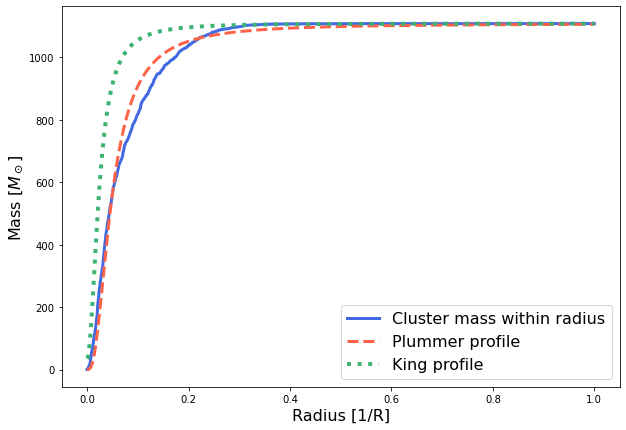

In [164]:
plt.figure(figsize=(10, 7))
plt.plot(radii/max(x_rad, y_rad, z_rad),
         radius_mass, color='royalblue', linewidth=3, label='Cluster mass within radius')
plt.plot(radii/max(x_rad, y_rad, z_rad),
         plummer(radii), color='tomato', linewidth=3, linestyle='--', label='Plummer profile')
plt.gca().set_xlabel('Radius [1/R]', fontsize=16)
plt.gca().set_ylabel('Mass [$M_\odot$]', fontsize=16)
plt.plot(radii/max(x_rad, y_rad, z_rad),
         (1-surface_density_king_profile(1., radii))*total_mass, color='mediumseagreen',
         linewidth=4, linestyle='dotted', label='King profile')

plt.legend(fontsize=16, loc='lower right')